In [28]:
from barney_functions import *
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import os
from tqdm import tqdm 
import soundfile as sf
import xarray as xr

In [2]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
nzebra_path = 'big bounce small.wav'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
zebra_labels = df['label']

Finding file lengths


100%|█████████████████████████████████████████| 413/413 [00:07<00:00, 52.47it/s]


Reducing to 97th percentile


100%|█████████████████████████████████████| 413/413 [00:00<00:00, 186644.49it/s]


Data size reduction:  1.003
Removed classes:  ['whinnie']
New max length:  21739
Number of samples removed: 13


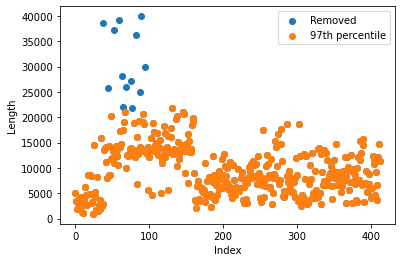

Padding


100%|███████████████████████████████████████| 400/400 [00:00<00:00, 8605.29it/s]


In [3]:
audio_size,audio_list_short,labels_short,idx_longest = length_finder(audio_path,df,97)
zebra_labels = pd.Series(data=labels_short, index=[np.arange(len(labels_short))])
audio_files = pad(audio_list_short,audio_size)

In [4]:
balanced, balanced_labels = balancer(audio_files,zebra_labels)

Initial class proportions:
[0.592 0.035 0.095 0.278]
----------------------
Balancing: snort
Multiplier: 1.0
----------------------
Balancing: softsnort
Multiplier: 10.0
----------------------
Balancing: squeal
Multiplier: 2.0
----------------------
Balancing: whinnie
Multiplier: 1.0
----------------------
Final class proportions:
[0.42  0.248 0.135 0.197]


In [6]:
augmented_audio = augment_audio_faster_smaller(balanced)

Augmenting 564 samples


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 730.98it/s]


In [7]:
print(augmented_audio.shape)
print("Augmented dataset size: ",augmented_audio.nbytes/(1e9), 'GB')

(4, 564, 26085)
Augmented dataset size:  0.47078208 GB


In [ ]:
mels = calc_melstft(augmented_audio)
mels_norm_db = librosa.util.normalize(librosa.power_to_db(mels))

In [19]:
mels_1D = np.zeros(mels_norm_db[0].shape)
mels_labels = balanced_labels
mels_1D = mels_norm_db[0]
print("Flattening")
for i in range(1,mels_norm_db.shape[0]):
    mels_1D = np.concatenate((mels_1D,mels_norm_db[i]), axis = 0)
    mels_labels = np.concatenate((mels_labels,balanced_labels))
print("Final data shape:",mels_1D.shape)
print("Final labels shape:",mels_labels.shape)
print("Final dataset size: ",mels_norm_db.nbytes/(1e9), 'GB')

Flattening
Final data shape: (2256, 128, 51)
Final labels shape: (2256,)
Final dataset size:  0.117817344 GB


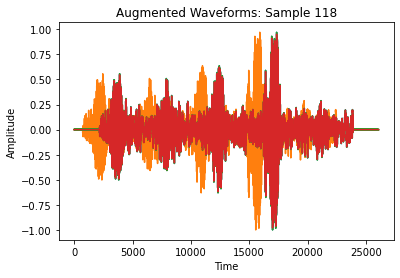

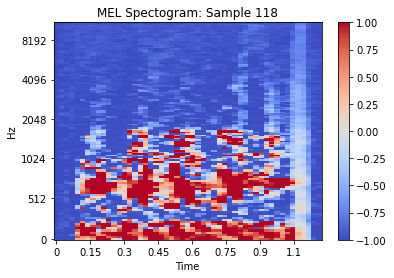

In [97]:
examplesample = idx_longest
plot_sample(augmented_audio,examplesample)
ax = librosa.display.specshow(mels_norm_db[2,examplesample,:,:],x_axis="time",y_axis="mel")
plt.colorbar()
plt.title("MEL Spectogram: Sample "+str(examplesample))
plt.show()
coords = ax.get_coordinates()
Times = coords[0,1:,0]
Hzs = coords[1:,0,1]

In [99]:
listen(augmented_audio[0,examplesample])
listen(librosa.feature.inverse.mel_to_audio(mels_norm_db[0,examplesample]))

In [93]:
Dataset = xr.DataArray(data=mels_1D,
                       dims=['Call','Hz','Time'],
                       coords = dict(
                           Call=mels_labels,
                           Time=Times,
                           Hz=Hzs)
                      )
Dataset

<xarray.DataArray (Call: 2256, Hz: 128, Time: 51)>
array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
...
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]])
Coordinates:
  * Call     (Call) object 'squeal' 'squeal' 'squeal' ... 'squeal' 'squeal'
  * Time     (Time) float64 0.01161 0.03483 0.05805 ... 1.126 1.149 1.173
  * Hz       (Hz) float64 13.1 39.3 65.5 91.7 ... 1.059e+04 1.088e+04 1.117e+04

In [101]:
np.savez_compressed('mels',data=mels_1D)
np.savez_compressed('mels_lables',data=mels_labels)

In [96]:
#Dataset.to_netcdf("Dataset.nc")

In [83]:
times = coords[0,1:,0]
Hzs = coords[1:,0,1]

array([   13.09989356,    39.29968069,    65.49946782,    91.69925495,
         117.89904208,   144.09882921,   170.29861634,   196.49840347,
         222.69819059,   248.89797772,   275.09776485,   301.29755198,
         327.49733911,   353.69712624,   379.89691337,   406.09670049,
         432.29648762,   458.49627475,   484.69606188,   510.89584901,
         537.09563614,   563.29542327,   589.4952104 ,   615.69499752,
         641.89478465,   668.09457178,   694.29435891,   720.49414604,
         746.69393317,   772.8937203 ,   799.09350743,   825.29329455,
         851.49308168,   877.69286881,   903.89265594,   930.09244307,
         956.2922302 ,   982.49201733,  1009.15980337,  1036.73270301,
        1065.12628025,  1094.29748825,  1124.2676244 ,  1155.05856941,
        1186.69280321,  1219.19342143,  1252.58415222,  1286.8893736 ,
        1322.13413122,  1358.3441567 ,  1395.54588635,  1433.76648055,
        1473.03384349,  1513.37664361,  1554.82433453,  1597.40717649,
      

In [ ]:
H